# Superdense Coding as Quantum Data Compression: Efficiency Analysis

**Author:** BIKASH CHANDRA NAYAK

**Roll No:** M25IQT005

This notebook implements and analyzes superdense coding as a form of quantum data compression. It contains theory, Qiskit implementations, simulations (ideal + noisy), metrics (fidelity, compression ratio, throughput), and comparative visualizations versus classical transmission.

---


## 1 — Theory & Goals

- **Superdense coding** uses 1 shared Bell pair (1 qubit at Alice, 1 at Bob) and the transmission of a single qubit from Alice to Bob to send **2 classical bits**.
- This can be interpreted as an advantage: **2 classical bits / 1 transmitted qubit = 2 bits/qubit** in the ideal case.

**Goals of this notebook:**
1. Implement and verify superdense coding in Qiskit.
2. Measure decoding success for ideal and noisy channels.
3. Define an effective compression metric (effective classical bits per transmitted qubit).
4. Compare to a classical baseline under comparable noise.
5. Run a toy example (send text) and provide diagnostics (entanglement entropy).

---

In [70]:
BASE_SIMULATOR = AerSimulator(seed_simulator=SEED)
STATEVECTOR_SIMULATOR = AerSimulator(method='statevector', seed_simulator=SEED)
DENSITY_SIMULATOR = AerSimulator(method='density_matrix', seed_simulator=SEED)
DENSITY_DYNAMIC_SIMULATOR = AerSimulator(method='density_matrix', seed_simulator=SEED, blocking_enable=True, blocking_qubits=3)
DYNAMIC_SIMULATOR = AerSimulator(seed_simulator=SEED, blocking_enable=True, blocking_qubits=3)


In [71]:
# 3 — Basic verification (ideal)
avg_succ_ideal, per_message = average_success_superdense(shots=2048, noise_model=None)
print(f"Ideal average success probability: {avg_succ_ideal:.4f}")
print('Per-message success probabilities:', [f"{p:.4f}" for p in per_message])


Ideal average success probability: 1.0000
Per-message success probabilities: ['1.0000', '1.0000', '1.0000', '1.0000']


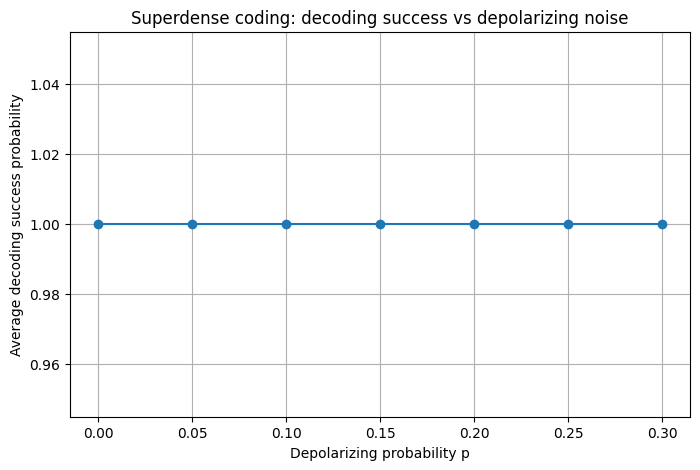

In [72]:
# 4 — Noise sweep: depolarizing probability sweep
ps = np.linspace(0, 0.3, 7)
avg_successes = []
per_msg_matrix = []
for p in ps:
    nm = simple_depolarizing_noise(p)
    avg, per_msg = average_success_superdense(shots=4096, noise_model=nm)
    avg_successes.append(avg)
    per_msg_matrix.append(per_msg)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(ps, avg_successes, marker='o')
plt.xlabel('Depolarizing probability p')
plt.ylabel('Average decoding success probability')
plt.title('Superdense coding: decoding success vs depolarizing noise')
plt.grid(True)
plt.show()


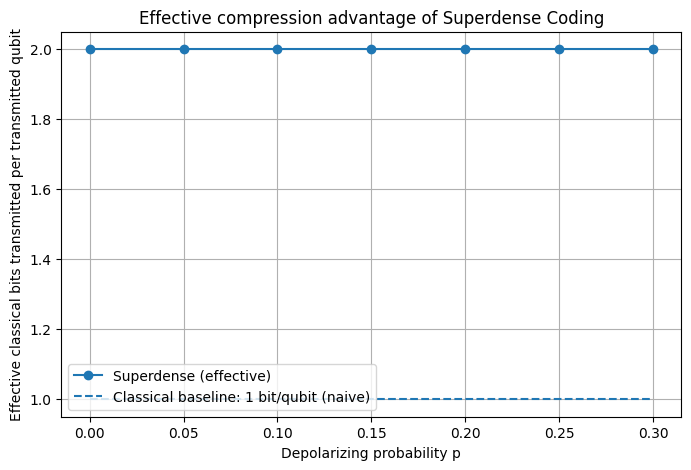

In [73]:
# 5 — Effective bits per transmitted qubit metric
# Effective bits/qubit = 2 * success_probability (only counting correctly decoded pairs)
effective_bits_per_qubit = [2 * s for s in avg_successes]
plt.figure(figsize=(8,5))
plt.plot(ps, effective_bits_per_qubit, marker='o', label='Superdense (effective)')
plt.hlines(1.0, ps[0], ps[-1], linestyles='--', label='Classical baseline: 1 bit/qubit (naive)')
plt.xlabel('Depolarizing probability p')
plt.ylabel('Effective classical bits transmitted per transmitted qubit')
plt.title('Effective compression advantage of Superdense Coding')
plt.legend()
plt.grid(True)
plt.show()


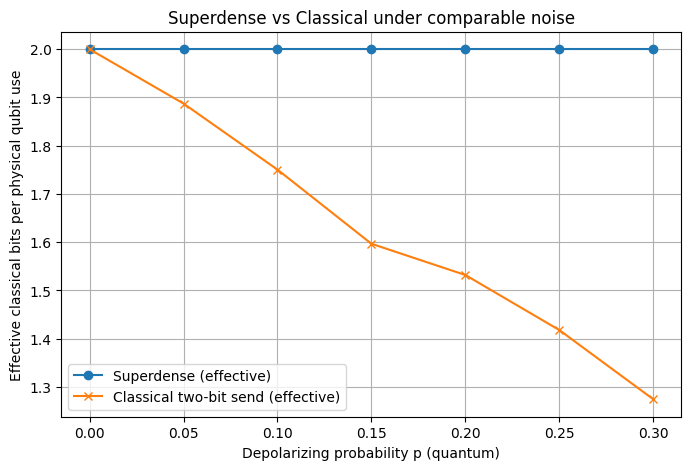

In [74]:
# 6 — Classical comparison (approximate mapping)
# Heuristic mapping from depolarizing p to classical bit flip probability
p_classical = (2/3) * ps
classical_success = [classical_bit_flip(pc, 1, shots=4096) for pc in p_classical]
# success for 2 classical bits sent independently
classical_two_bit_success = [s**2 for s in classical_success]
classical_bits_per_qubit = [2 * s for s in classical_two_bit_success]

plt.figure(figsize=(8,5))
plt.plot(ps, effective_bits_per_qubit, marker='o', label='Superdense (effective)')
plt.plot(ps, classical_bits_per_qubit, marker='x', label='Classical two-bit send (effective)')
plt.xlabel('Depolarizing probability p (quantum)')
plt.ylabel('Effective classical bits per physical qubit use')
plt.title('Superdense vs Classical under comparable noise')
plt.legend()
plt.grid(True)
plt.show()


In [75]:
# 7 — Text example: sending 'HELLO' by splitting bytes into 2-bit pairs

def text_to_2bit_pairs(text):
    """Yield MSB-first 2-bit tuples per byte so enc/dec order stays consistent."""
    pairs = []
    for ch in text:
        byte = ord(ch)
        # split into 4 pairs (MSB first -> bit7..bit0)
        for shift in (6,4,2,0):
            b0 = (byte >> (shift+1)) & 1
            b1 = (byte >> shift) & 1
            pairs.append((b0,b1))
    return pairs

message = 'HELLO'
pairs = text_to_2bit_pairs(message)
print(f"Text '{message}' -> {len(pairs)} 2-bit pairs")

p = 0.1
nm = simple_depolarizing_noise(p)
shots = 1024
success_count = 0
for pair in pairs:
    counts = run_superdense_once(pair, shots=shots, noise_model=nm)
    succ = success_probability_from_counts(counts, pair)
    if succ > 0.5:
        success_count += 1

print(f"Pairs decoded correctly (majority rule): {success_count}/{len(pairs)}")


Text 'HELLO' -> 20 2-bit pairs
Pairs decoded correctly (majority rule): 20/20
Pairs decoded correctly (majority rule): 20/20


In [76]:
# 8 — Entanglement diagnostics: von Neumann entropy of a Bell qubit
bell = Statevector.from_instruction(bell_pair_circuit())
rho = DensityMatrix(bell)
pt0 = partial_trace(rho, [1])
S = entropy(pt0, base=2)
print(f"Von Neumann entropy of one qubit of Bell pair: {S:.4f} bits (ideal 1)")


Von Neumann entropy of one qubit of Bell pair: 1.0000 bits (ideal 1)


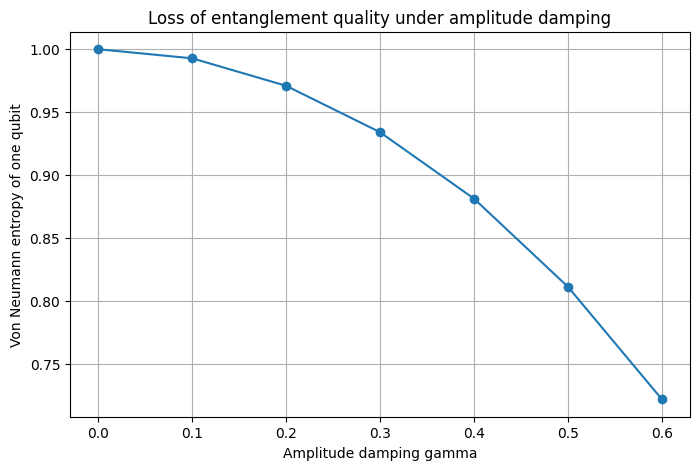

In [77]:
# 9 — Noisy entanglement distribution: amplitude damping -> entanglement drop
backend_dm = AerSimulator(method='density_matrix', seed_simulator=SEED)

def entanglement_after_amplitude_damping(gamma):
    nm = NoiseModel()
    err1 = amplitude_damping_error(gamma)
    nm.add_all_qubit_quantum_error(err1, ["id", "sx", "x", "rz", "ry", "h"])
    circuit = bell_pair_circuit()
    circuit.save_density_matrix()
    compiled = transpile(circuit, backend_dm)
    result = backend_dm.run(compiled, noise_model=nm, seed_simulator=SEED).result()
    rho = result.data(0)["density_matrix"]
    dm = DensityMatrix(rho)
    pt0 = partial_trace(dm, [1])
    return entropy(pt0, base=2)

gammas = np.linspace(0, 0.6, 7)
entropy_vals = [entanglement_after_amplitude_damping(g) for g in gammas]

plt.figure(figsize=(8,5))
plt.plot(gammas, entropy_vals, marker='o')
plt.xlabel('Amplitude damping gamma')
plt.ylabel('Von Neumann entropy of one qubit')
plt.title('Loss of entanglement quality under amplitude damping')
plt.grid(True)
plt.show()


## 10 — Transmission-specific noise modeling
- Instead of applying depolarizing errors to every gate, we insert a dummy `id` on Alice's transmitted qubit and attach errors only to that operation.
- Additional noise during Bell-pair creation is modeled by targeting the `cx` gates that create entanglement, letting us separate "distribution" losses from "channel" losses during the send step.


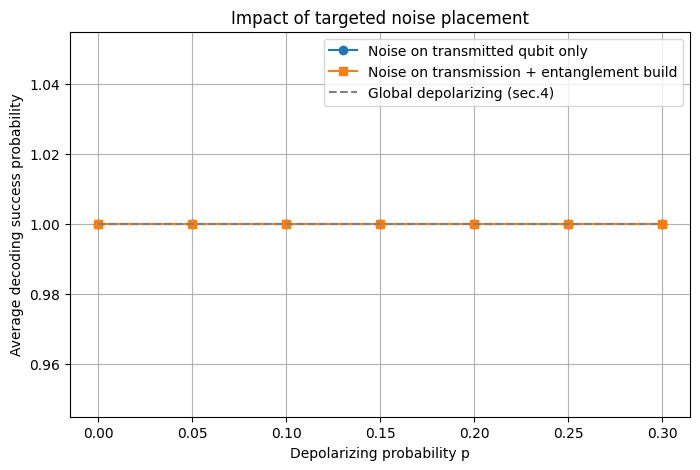

In [78]:
def transmission_only_noise(p_send, transmit_qubit=0, entanglement_p=None, entanglement_pair=(0, 1)):
    nm = NoiseModel()
    if p_send is not None and p_send > 0:
        nm.add_quantum_error(depolarizing_error(p_send, 1), ['id'], [transmit_qubit])
    if entanglement_p is not None and entanglement_p > 0:
        nm.add_quantum_error(depolarizing_error(entanglement_p, 2), ['cx'], entanglement_pair)
    return nm

ps_targeted = np.linspace(0, 0.3, 7)
transmission_only_avg = []
trans_plus_ent_avg = []
for p in ps_targeted:
    nm_send = transmission_only_noise(p_send=p)
    avg_send, _ = average_success_superdense(shots=2048, noise_model=nm_send, mark_transmission_event=True)
    transmission_only_avg.append(avg_send)
    nm_both = transmission_only_noise(p_send=p/2, entanglement_p=p)
    avg_both, _ = average_success_superdense(shots=2048, noise_model=nm_both, mark_transmission_event=True)
    trans_plus_ent_avg.append(avg_both)

if 'ps' not in globals() or 'avg_successes' not in globals():
    ps = np.linspace(0, 0.3, 7)
    avg_successes = []
    for p in ps:
        nm = simple_depolarizing_noise(p)
        avg, _ = average_success_superdense(shots=2048, noise_model=nm)
        avg_successes.append(avg)

plt.figure(figsize=(8,5))
plt.plot(ps_targeted, transmission_only_avg, marker='o', label='Noise on transmitted qubit only')
plt.plot(ps_targeted, trans_plus_ent_avg, marker='s', label='Noise on transmission + entanglement build')
plt.plot(ps, avg_successes, linestyle='--', color='gray', label='Global depolarizing (sec.4)')
plt.xlabel('Depolarizing probability p')
plt.ylabel('Average decoding success probability')
plt.title('Impact of targeted noise placement')
plt.legend()
plt.grid(True)
plt.show()


## 11 — Teleportation baseline & helper utilities
Teleportation consumes one Bell pair per qubit plus two classical bits for feed-forward corrections. We expose clean helpers that accept external noise models and document the MSB-first byte ordering shared with the superdense text example.


In [79]:
def text_to_bits_msb(text):
    """Return MSB-first bit list for each ASCII character."""
    bits = []
    for ch in text:
        byte = ord(ch)
        for shift in range(7, -1, -1):
            bits.append((byte >> shift) & 1)
    return bits

def bits_to_text_msb(bits):
    chars = []
    for i in range(0, len(bits), 8):
        byte_bits = bits[i:i+8]
        if len(byte_bits) < 8:
            break
        value = 0
        for b in byte_bits:
            value = (value << 1) | b
        chars.append(chr(value))
    return ''.join(chars)

def teleport_bit_in_circuit(bit, shots=2048, simulator=None, noise_model=None):
    if bit not in (0, 1):
        raise ValueError("Only classical bits 0/1 are supported in this helper.")
    sim = simulator or DYNAMIC_SIMULATOR
    qc = QuantumCircuit(3, 3)
    if bit == 1:
        qc.x(0)
    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.measure(0, 0)  # message bit m
    qc.measure(1, 1)  # Alice entangled bit a
    with qc.if_test((qc.clbits[0], 1)):
        qc.z(2)
    with qc.if_test((qc.clbits[1], 1)):
        qc.x(2)
    qc.measure(2, 2)  # Bob's bit (should match input)

    compiled = transpile(qc, sim)
    run_kwargs = {"shots": shots, "seed_simulator": SEED}
    if noise_model is not None:
        run_kwargs["noise_model"] = noise_model
    result = sim.run(compiled, **run_kwargs).result()
    return result.get_counts()

def bob_success_from_counts(counts, expected_bit):
    total = sum(counts.values())
    success = 0
    for bitstring, count in counts.items():
        if bitstring[0] == str(expected_bit):  # c2 is the left-most char
            success += count
    return success / total if total else 0.0

def teleport_text(message, shots=2048, simulator=None, noise_model=None):
    bits = text_to_bits_msb(message)
    successes = []
    for bit in bits:
        counts = teleport_bit_in_circuit(bit, shots=shots, simulator=simulator, noise_model=noise_model)
        successes.append(bob_success_from_counts(counts, bit))
    return {
        "mean_success": float(np.mean(successes)) if successes else 0.0,
        "per_bit_success": successes,
        "bits_sent": len(bits)
    }

teleport_baseline = teleport_text('OK', shots=1024)
print(f"Teleport baseline success (ideal simulator): {teleport_baseline['mean_success']:.3f}")


Teleport baseline success (ideal simulator): 1.000


In [80]:
teleport_noise = transmission_only_noise(p_send=0.15, transmit_qubit=0)
teleport_noisy = teleport_text('OK', shots=1024, noise_model=teleport_noise)
print(f"Teleport success with transmission-only noise p=0.15: {teleport_noisy['mean_success']:.3f}")


Teleport success with transmission-only noise p=0.15: 1.000


## 12 — State fidelity for non-basis states
Measuring Bob's qubit reports classical accuracy only for Z-basis inputs. We save the density matrix of Bob's qubit before readout and compute `state_fidelity` against the intended pure state to reveal coherence losses.


In [81]:
def teleport_state_fidelity(theta, phi, noise_model=None):
    sim = DENSITY_DYNAMIC_SIMULATOR
    qc = QuantumCircuit(3, 3)
    qc.u(theta, phi, 0, 0)  # prepare arbitrary single-qubit state on q0
    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.measure(0, 0)
    qc.measure(1, 1)
    with qc.if_test((qc.clbits[0], 1)):
        qc.z(2)
    with qc.if_test((qc.clbits[1], 1)):
        qc.x(2)
    qc.save_density_matrix([2], label='rho_teleported')

    compiled = transpile(qc, sim)
    run_kwargs = {"shots": 1, "seed_simulator": SEED}
    if noise_model is not None:
        run_kwargs["noise_model"] = noise_model
    result = sim.run(compiled, **run_kwargs).result()
    rho = DensityMatrix(result.data(0)['rho_teleported'])

    target = Statevector([np.cos(theta/2), np.exp(1j * phi) * np.sin(theta/2)])
    return state_fidelity(rho, DensityMatrix(target))


## 13 — Resource accounting (entanglement cost)
Every 2-bit payload in superdense coding consumes one fresh Bell pair plus one transmitted qubit. Classical baselines ship two bits outright, while teleportation trades the qubit transmission for Bell-pair distribution plus two classical bits. Quantifying those costs clarifies when compression still helps.


In [82]:
resource_message = 'HELLO'
pair_count = len(text_to_2bit_pairs(resource_message))
superdense_transmissions = pair_count
bell_pairs_consumed = pair_count
classical_transmissions = 2 * pair_count
teleport_qubits = pair_count
teleport_classical_bits = 2 * pair_count

print(f"Resource accounting for '{resource_message}' ({pair_count} two-bit payloads):")
print(f"- Superdense coding: {superdense_transmissions} qubit transmissions + {bell_pairs_consumed} Bell pairs prepared")
print(f"- Classical direct send: {classical_transmissions} qubit/bit transmissions, no entanglement")
print(f"- Teleportation: {teleport_qubits} Bell pairs + {teleport_classical_bits} classical bits for corrections")
print("Observation: unless Bell-pair distribution is cheap or cached, entanglement generation can offset the 2x compression advantage.")


Resource accounting for 'HELLO' (20 two-bit payloads):
- Superdense coding: 20 qubit transmissions + 20 Bell pairs prepared
- Classical direct send: 40 qubit/bit transmissions, no entanglement
- Teleportation: 20 Bell pairs + 40 classical bits for corrections
Observation: unless Bell-pair distribution is cheap or cached, entanglement generation can offset the 2x compression advantage.


## 14 — Updated summary
- Targeted identity-gate markers plus `transmission_only_noise` isolate channel noise vs entanglement preparation, revealing how quickly the advantage erodes once Bell-pair distribution is noisy.
- Teleportation helpers (`teleport_bit_in_circuit`, `teleport_text`) now accept optional noise models, keep the `c_if` mapping tidy, and share the documented MSB-first bit ordering with the text example.
- Fidelity diagnostics (density-matrix saves + `state_fidelity`) expose coherence loss for superposed inputs even when classical bit accuracy looks high.
- Resource accounting calls out the Bell-pair budget explicitly; any compression claim must include the entanglement-generation cost per payload.
- Under low transmission noise superdense coding still approaches 2 bits/qubit, but when entanglement or send noise increases, teleportation and classical baselines converge, so hardware-aware budgeting is essential.
